In [1]:
from Bio import SeqIO, Entrez
import os
from urllib.error import HTTPError
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import permutations, product
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
import tqdm
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score

from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score

from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


%cd ../utils
import model_utils
import validation_utils
%cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)


/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project


In [2]:
df = pd.read_csv('data/info.csv')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.6, random_state=None)
# X_test = df.loc[:, df.columns != 'isZoonotic']
# y_test = df['isZoonotic']

In [4]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

curr_dir = 'models/curr_models'
best_xgboost = pickle.load(open(f'{curr_dir}/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open(f'{curr_dir}/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open(f'{curr_dir}/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open(f'{curr_dir}/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open(f'{curr_dir}/randforest.pkl', 'rb'))

lrmodel = pickle.load(open(f'{curr_dir}/lrmodel.pkl', 'rb'))


nardus_gradBoost = pickle.load(open(f'models/nardus_gridsearch.pkl', 'rb'))

mlp = pickle.load(open(f'{curr_dir}/mlpClassifier.pkl', 'rb'))


validation_utils.cross_validate(nardus_gradBoost.best_estimator_, X_test, y_test)
# val_utils.cross_validate(mlp,X_test, y_test)

validation_utils.cross_validate(best_xgboost,X_test, y_test)
validation_utils.cross_validate(best_gradBoost,X_test, y_test)
validation_utils.cross_validate(best_rF,X_test, y_test)
validation_utils.cross_validate(lrmodel,X_test, y_test)

GradientBoostingClassifier
gradboost
Accuracy: 0.955 (0.008)
tn: 4920, fp: 12, fn: 31, tp: 695
XGBClassifier
xgboost
Accuracy: 0.957 (0.008)
tn: 4921, fp: 11, fn: 30, tp: 696
GradientBoostingClassifier
gradboost
Accuracy: 0.953 (0.008)
tn: 4922, fp: 10, fn: 34, tp: 692
BalancedBaggingClassifier
Accuracy: 0.917 (0.013)
tn: 4720, fp: 212, fn: 33, tp: 693
LogisticRegression
Accuracy: 0.934 (0.008)
tn: 4836, fp: 96, fn: 724, tp: 2


GradientBoostingClassifier
gradboost
precision recall: 0.9891944434975783
[0.00377316 0.9942059  0.96414563 ... 0.00251143 0.01221259 0.0038157 ]


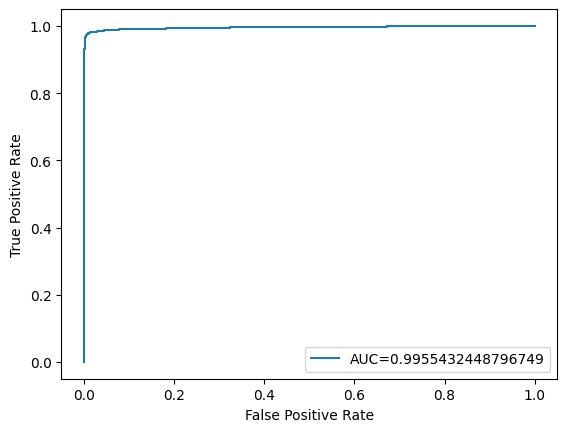

In [5]:
# ALWAYS reset X columns to the right order
validation_utils.draw_roc_curve(nardus_gradBoost.best_estimator_, X_test, y_test)

XGBClassifier
xgboost
precision recall: 0.9916138067484331
[5.9163111e-04 9.8485106e-01 4.9552236e-05 ... 5.9699215e-04 3.2488885e-03
 5.3126176e-05]


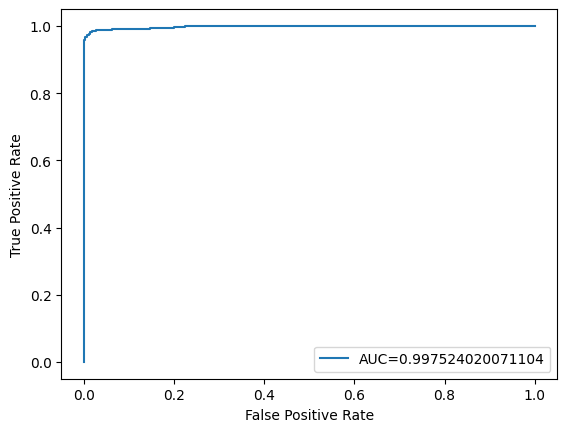

In [15]:
validation_utils.draw_roc_curve(best_xgboost, X_test, y_test)

BalancedBaggingClassifier
precision recall: 0.95701092433972
[0.3 1.  0.  ... 0.1 0.3 0. ]


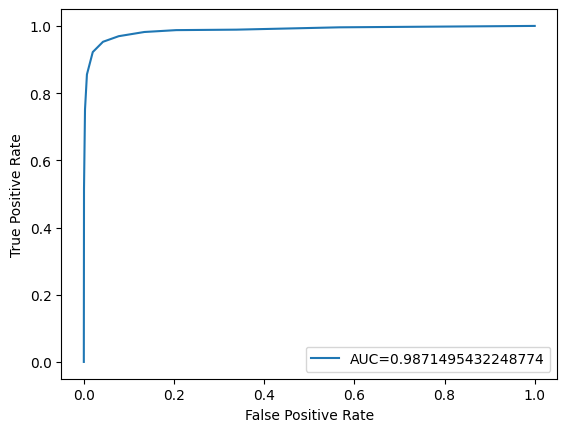

In [7]:
validation_utils.draw_roc_curve(best_rF, X_test, y_test)

GradientBoostingClassifier
gradboost
precision recall: 0.9888874222226423
[0.01221607 0.82838265 0.00141318 ... 0.0012264  0.00981427 0.00125163]


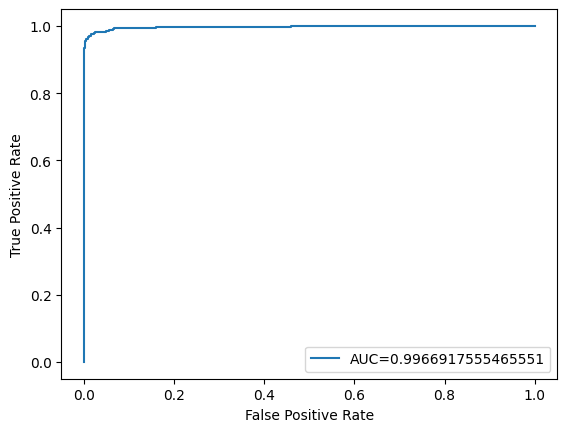

In [9]:
validation_utils.draw_roc_curve(best_gradBoost, X_test, y_test)

MLPClassifier
precision recall: 0.9774674460705072
[1.03496838e-04 9.90507665e-01 2.69827159e-10 ... 7.41607458e-03
 1.04549419e-02 3.60858984e-07]


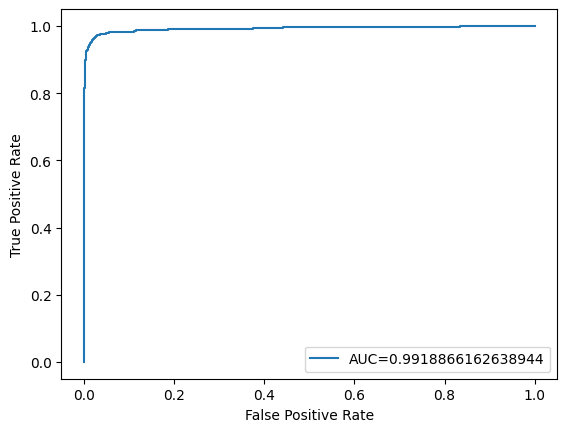

In [10]:
validation_utils.draw_roc_curve(mlp, X_test, y_test)

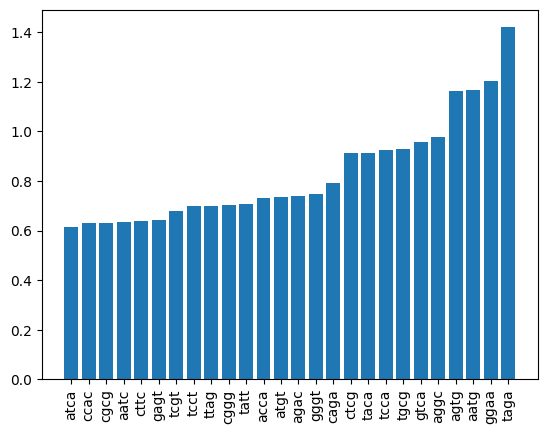

In [ ]:
results = lrmodel.coef_[0]

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in res[230:]], [x[1] for x in res[230:]])
plt.show()

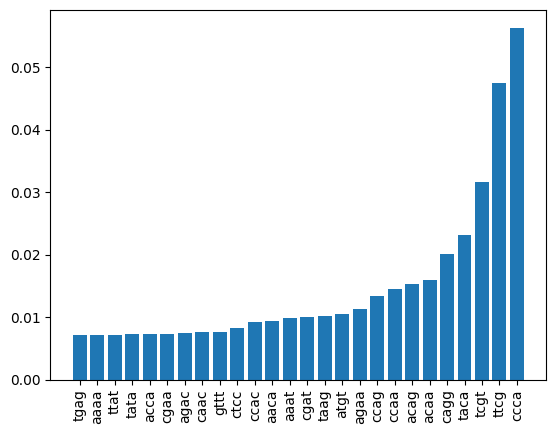

In [ ]:
results = best_xgboost.feature_importances_

l = zip([x for x in X_test.columns.values],results)
l = list(l)
resxG = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resxG[230:]], [x[1] for x in resxG[230:]])
plt.show()

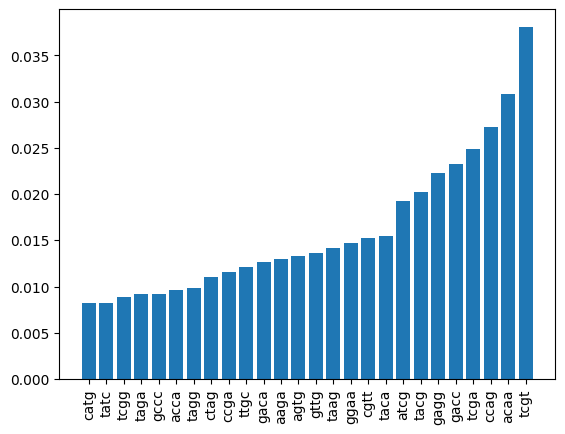

In [ ]:
results = best_gradBoost.feature_importances_

l = zip([x for x in X_test.columns.values],results)
l = list(l)
resgB = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resgB[230:]], [x[1] for x in resgB[230:]])
plt.show()

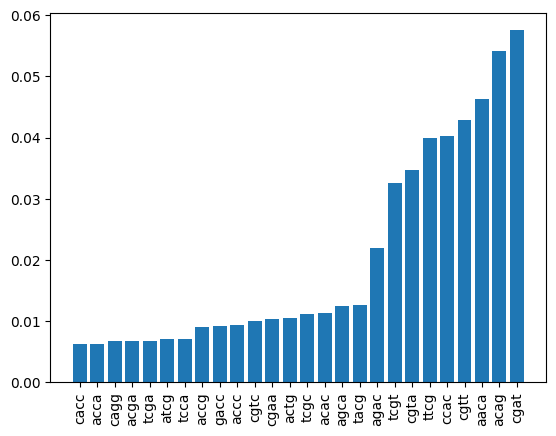

In [ ]:
# get feature importances as a mean of feature importances PER tree
results = np.mean([est.steps[1][1].feature_importances_ for est in best_rF.estimators_], axis=0)


l = zip([x for x in X_test.columns.values],results)
l = list(l)
resrF = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resrF[230:]], [x[1] for x in resrF[230:]])
plt.show()

In [ ]:
max_bound = 3
for x in range(len(resrF)-max_bound+1):
    for i in range(max_bound):
        if resrF[x][0] == resgB[x+i][0]:  print("rF & gb bound", i, resrF[x], x)
        if resrF[x][0] == resxG[x+i][0]:  print("rF & xg bound", i, resrF[x], x)
        if resgB[x][0] == resxG[x+i][0]:  print("gb & xg bound", i, resgB[x], x)

rF & gb bound 1 ('cgcg', 0.0003015572826893574) 12
rF & xg bound 0 ('cgac', 0.0005925319998248206) 21
rF & gb bound 1 ('tatt', 0.0011150453509348468) 60
rF & gb bound 0 ('ctcg', 0.001601226302398424) 96
rF & xg bound 2 ('taac', 0.0016960808192351047) 105
rF & xg bound 1 ('caaa', 0.0018456698283735272) 115
gb & xg bound 1 ('agct', 0.002219047867503112) 122
rF & xg bound 1 ('ctca', 0.0020714853411268937) 132
rF & gb bound 2 ('gaac', 0.0025670387790062968) 151
gb & xg bound 0 ('taag', 0.014197001200931161) 244
